In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

loaded = joblib.load('Data/Fake_Real_News_Data.joblib')
df = loaded['df']
# Join list of lemmas into a string with spaces between each lemma
df['lemmas-joined'] = df['lemmas'].apply(lambda x: " ".join(x))
df.head()

,title,text,label,tokens,lemmas,lemmas-joined
0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL,"[donald, trump, endorsed, an, unabashedly, non...","[donald, trump, endorse, unabashedly, noninter...",donald trump endorse unabashedly noninterventi...
1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL,"[while, some, justice, department, investigati...","[justice, department, investigation, adversari...",justice department investigation adversarial n...
2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE,"[trump, proudly, declares, :, most, of, the, p...","[trump, proudly, declare, people, insult, dese...",trump proudly declare people insult deserved a...
3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL,"[donald, trump, spent, a, day, in, january, 20...","[donald, trump, spend, day, january, 2014, hob...",donald trump spend day january 2014 hobnob pol...
4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL,"[notable, names, include, ray, washburne, (, c...","[notable, name, include, ray, washburne, comme...",notable name include ray washburne commerce da...


# Prepare the Data for classification model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X=df['lemmas-joined']
y=df['label']
# Checking class balance 
y.value_counts(normalize=True)

REAL    0.500552
FAKE    0.499448
Name: label, dtype: float64

In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), # This is just a placeholder
                     ('clf',MultinomialNB())])

In [5]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf] 

In [6]:
# Define parameters to tune multiple models

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [param_grid_MNB, param_grid_logreg]

In [7]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
len(paired_param_grids)

4

In [8]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [MultinomialNB()],
 'clf__alpha': [0.5, 1]}

In [9]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
CPU times: total: 7min 31s
Wall time: 1h 16min 12s


C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [MultinomialNB()], 'clf__alpha': [0.5, 1],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__stop_words': [None, 'englis...
                         {'clf': [LogisticRegression(C=100, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=2,
                                                         stop_words='english')],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2393
        REAL       1.00      1.00      1.00      2358

    accuracy                           1.00      4751
   macro avg       1.00      1.00      1.00      4751
weighted avg       1.00      1.00      1.00      4751



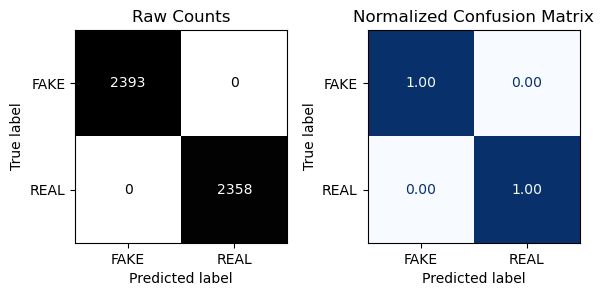


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.91      0.95      0.93       771
        REAL       0.95      0.92      0.93       813

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



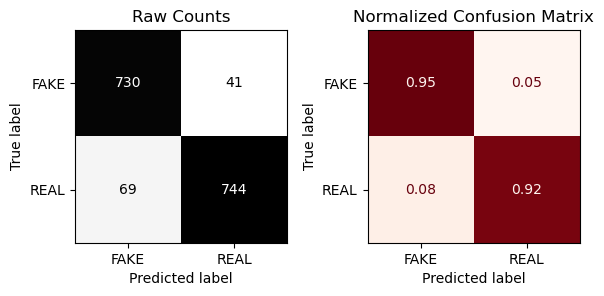

In [10]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

In [12]:
# Obtain the best combination directly
grid_search.best_params_

{'clf': LogisticRegression(C=100, random_state=42),
 'clf__C': 100,
 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2, stop_words='english'),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': 'english',
 'vectorizer__use_idf': True}